# SNA Project- COVID Outbreak Network Analysis
Swetha Saseendran <br>
Tarun V <br>
Vishal T <br>
Swetha P 

## Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly
import plotly.express as px

import networkx as nx
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering


## Importing Original Dataset

In [ ]:
df_in = pd.read_csv('time_series_covid_19_deaths.csv')
df_in.iloc[:, 1:10].head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0
1,Albania,41.1533,20.1683,0,0,0,0,0,0
2,Algeria,28.0339,1.6596,0,0,0,0,0,0
3,Andorra,42.5063,1.5218,0,0,0,0,0,0
4,Angola,-11.2027,17.8739,0,0,0,0,0,0


## Finding Network from the data

In [ ]:
dates_vec = list(df_in.columns)[3:]
average_time_vec = [None] * df_in.shape[0]

for i, row_index in enumerate(df_in.index):
  weighted_sum, total_deaths = 0, 0
  for j, date in enumerate(dates_vec):
    current_term = df_in.at[row_index, date]
    weighted_sum += j * current_term
    total_deaths += current_term
  
  average_time_vec[i] = weighted_sum/total_deaths

df_in['avg_time'] = average_time_vec

n_lines = int((df_in.shape[0] * (df_in.shape[0] - 1)) / 2)
list_country1, list_country2, list_w, list_d = [None] * n_lines, [None] * n_lines, [None] * n_lines, [None] * n_lines

line_index = 0
epsilon = 0.001

for i in range(0, df_in.shape[0] - 1):
  for j in range(i + 1, df_in.shape[0]):
    index_i, index_j = df_in.index[i], df_in.index[j]
    list_country1[line_index] = df_in.at[index_i, 'Country/Region']
    list_country2[line_index] = df_in.at[index_j, 'Country/Region']
    diff_time = df_in.at[index_i, 'avg_time'] - df_in.at[index_j,'avg_time']
    list_w[line_index] = (1 / (abs(diff_time) + epsilon))
    list_d[line_index] = abs(diff_time)
    line_index += 1

df_graph = pd.DataFrame(dict(
    Source = list_country1,
    Target = list_country2,
    Weight = list_w,
    Distance = list_d
))

df_graph.head()



,Source,Target,Weight,Distance
0,Afghanistan,Albania,0.071858,13.915422
1,Afghanistan,Algeria,0.111620,8.957965
2,Afghanistan,Andorra,0.098064,10.196457
3,Afghanistan,Angola,0.131006,7.632229
4,Afghanistan,Antigua and Barbuda,0.032748,30.535330


In [ ]:
df_graph= pd.read_csv('df_graph.csv')
df_graph.head()

,Source,Target,Weight,Distance
0,Afghanistan,Albania,0.065238,15.327436
1,Afghanistan,Algeria,0.113813,8.785341
2,Afghanistan,Andorra,0.090503,11.048355
3,Afghanistan,Angola,0.048136,20.773406
4,Afghanistan,Antigua and Barbuda,0.021892,45.677852


In [ ]:
cond = df_graph['Source'] == 'China'
china_res = df_graph[cond]
print(china_res.head)

cond = df_graph['Source'] == 'Brunei'
china_res = df_graph[cond]
print(china_res.head)

cond = df_graph['Source'] == 'Canada'
canada_res = df_graph[cond]
print(canada_res.head)

<bound method NDFrame.head of       Source                 Target    Weight   Distance
11809  China                  China  0.156182   6.401779
11810  China                  China  3.651802   0.272837
11811  China                  China  0.035621  28.072357
11812  China                  China  0.075928  13.169344
11813  China                  China  0.173744   5.754599
...      ...                    ...       ...        ...
18404  China  Sao Tome and Principe  0.012161  82.226047
18405  China                  Yemen  0.011619  86.067679
18406  China                Comoros  0.038403  26.038802
18407  China             Tajikistan  0.012728  78.567151
18408  China                Lesotho  0.024493  40.827648

[6600 rows x 4 columns]>
<bound method NDFrame.head of       Source                 Target    Weight   Distance
7279  Brunei               Bulgaria  0.014579  68.590696
7280  Brunei           Burkina Faso  0.015979  62.580831
7281  Brunei             Cabo Verde  0.011587  86.300798
72

## Network Analysis

In [ ]:
fig = px.histogram(x=df_graph['Weight'])
fig.update_layout(yaxis_type='log', title='Edges Weight Histogram', xaxis_title='Weight', yaxis_title='Count (Log)')

In [ ]:
covid_graph = nx.from_pandas_edgelist(df_graph, 'Source', 'Target', 'Weight')
w_degrees = covid_graph.degree(weight='Weight')
df_w_degrees = pd.DataFrame(w_degrees, columns=['Country', 'Degree'])
df_w_degrees.head(180)

,Country,Degree
0,Afghanistan,158.746381
1,Albania,56.298105
2,Algeria,171.829500
3,Andorra,172.363227
4,Angola,20.076383
...,...,...
175,Burma,16.055575
176,MS Zaandam,272.965871
177,Botswana,5.998567
178,Burundi,5.229969


In [ ]:
fig = px.histogram(x=df_w_degrees['Degree'])
fig.update_layout(yaxis_type='log', title='Weighted Degrees', xaxis_title='Weighted Deg.', yaxis_title='Count (Log)')

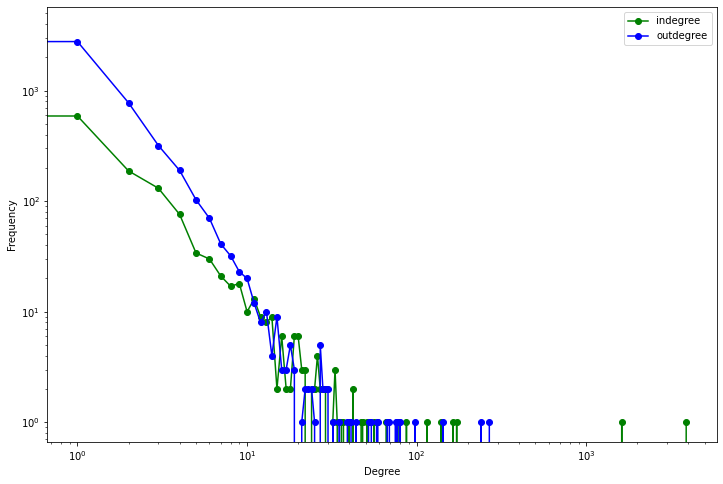

In [ ]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq


g = nx.scale_free_graph(5000)

in_degree_freq = degree_histogram_directed(g, in_degree=True)
out_degree_freq = degree_histogram_directed(g, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
# handles, labels = plt.get_legend_handles_labels()
plt.legend(["indegree", "outdegree"])


In [ ]:
fig = px.histogram(x=df_w_degrees.query('Degree < 20000')['Degree'])
fig.update_layout(yaxis_type='log', title='Weighted Degrees', xaxis_title='Weighted Deg.', yaxis_title='Count (Log)')

In [ ]:
df_w_degrees.query('Degree > 20000').sort_values('Degree', ascending=False)

,Country,Degree
28,Canada,24001.506158
56,France,22001.524245
106,Netherlands,22001.524222
154,United Kingdom,22001.507792
18,Bhutan,22001.506158
132,Seychelles,22001.506158
173,Saint Kitts and Nevis,22001.506158
168,Laos,22001.506158
166,Timor-Leste,22001.506158
163,Grenada,22001.506158


In [ ]:
graph_distance = nx.from_pandas_edgelist(df_graph, 'Source', 'Target', 'Weight')
adj_matrix = nx.adjacency_matrix(graph_distance, weight='Weight')
adj_matrix

<188x188 sparse matrix of type '<class 'numpy.float64'>'
	with 35163 stored elements in Compressed Sparse Row format>

In [ ]:
graph_distance._node.keys()

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'K

In [ ]:
#fig = px.histogram(x=df_graph['Distance'])
fig = px.histogram(x=df_graph.query('Distance < 20')['Distance'])
fig.update_layout(yaxis_type='log', title='Distances Distribution', xaxis_title='Dist.', yaxis_title='Count (Log)')

## Clustering for community detection

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

Text(0.5, 1.0, 'Dendrogram - Hierarchical Clustering')

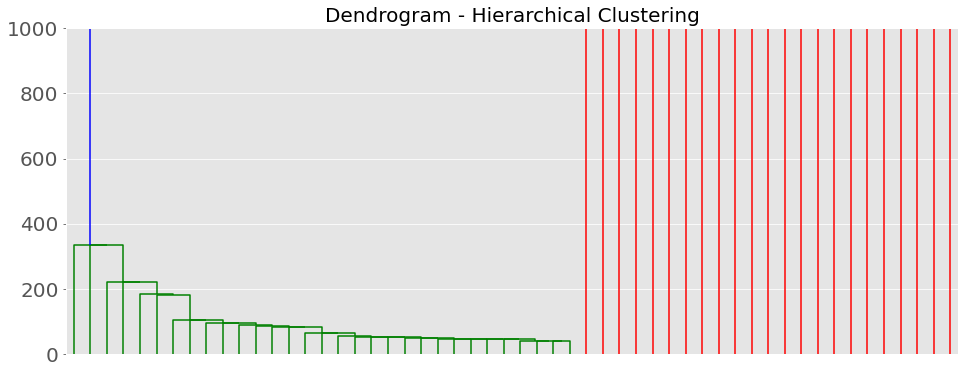

In [ ]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.style.use('ggplot')
D = dendrogram(linkage(adj_matrix.todense()), no_labels=True, truncate_mode='level')
plt.ylim(0, 1000)
plt.yticks(fontsize=20)

In [ ]:
ac_model = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='complete')
ac_model

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

In [ ]:
ac_model.fit(adj_matrix.toarray())
ac_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1])

In [ ]:
df_classification = pd.DataFrame(dict(Country=list(graph_distance._node.keys()), Label=ac_model.labels_.tolist()))
df_classification.to_csv('df_classification.csv', index=False)
df_classification.head()

,Country,Label
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Andorra,0
4,Angola,0


In [ ]:
df_classification.query('Label < 2')

,Country,Label
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Andorra,0
4,Angola,0
...,...,...
182,Western Sahara,0
183,Sao Tome and Principe,0
184,Yemen,0
185,Comoros,0


In [ ]:
print(df_classification[df_classification['Country'] == 'China'].Label)
print(df_classification[df_classification['Label'] == 2])
print(df_classification[df_classification['Label'] == 0])
print(df_classification[df_classification['Label'] == 1])

32    0
Name: Label, dtype: int64
                    Country  Label
14                 Barbados      2
20   Bosnia and Herzegovina      2
24             Burkina Faso      2
126             Saint Lucia      2
170      West Bank and Gaza      2
186              Tajikistan      2
                   Country  Label
0              Afghanistan      0
1                  Albania      0
2                  Algeria      0
3                  Andorra      0
4                   Angola      0
..                     ...    ...
181            South Sudan      0
182         Western Sahara      0
183  Sao Tome and Principe      0
184                  Yemen      0
185                Comoros      0

[177 rows x 2 columns]
     Country  Label
74      Iraq      1
80    Jordan      1
115   Panama      1
130  Senegal      1
187  Lesotho      1


## Visualising Clusters

In [ ]:
communities = pd.read_csv('df_classification_2.csv')
communities.head()

,Country,Label
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Andorra,0
4,Angola,0


In [ ]:
print(communities[communities['Country'] == 'China'].Label)
print(communities[communities['Label'] == 2])
print(communities[communities['Label'] == 0])
print(communities[communities['Label'] == 1])

32    0
Name: Label, dtype: int64
           Country  Label
12         Bahrain      2
56          France      2
64          Guinea      2
72       Indonesia      2
77           Italy      2
100         Monaco      2
102     Montenegro      2
136        Somalia      2
171  Guinea-Bissau      2
181    South Sudan      2
185        Comoros      2
                   Country  Label
0              Afghanistan      0
1                  Albania      0
2                  Algeria      0
3                  Andorra      0
4                   Angola      0
..                     ...    ...
179           Sierra Leone      0
180                 Malawi      0
182         Western Sahara      0
183  Sao Tome and Principe      0
184                  Yemen      0

[171 rows x 2 columns]
        Country  Label
42      Czechia      1
80       Jordan      1
140       Sudan      1
142      Sweden      1
186  Tajikistan      1
187     Lesotho      1


In [ ]:
print(communities[communities['Country'] == 'Italy'].Label)
print(communities[communities['Country'] == 'France'].Label)

77    2
Name: Label, dtype: int64
56    2
Name: Label, dtype: int64


In [ ]:
comm_0 = communities[communities['Label'] == 0]
comm_1 = communities[communities['Label'] == 1]
comm_2 = communities[communities['Label'] == 2]

In [ ]:
comm_2

,Country,Label
12,Bahrain,2
56,France,2
64,Guinea,2
72,Indonesia,2
77,Italy,2
100,Monaco,2
102,Montenegro,2
136,Somalia,2
171,Guinea-Bissau,2
181,South Sudan,2


In [ ]:
all_edges=[]
for i in range(len(df_graph)):
  all_edges.append([df_graph.iloc[i,0],df_graph.iloc[i,1]])

In [ ]:
def edge_find(comm_list):
  comm_edges = []
  for edge in all_edges:
    if(edge[0] in comm_list and edge[1] in comm_list):
      comm_edges.append(edge)
  return comm_edges

In [ ]:
edges_0 = edge_find(comm_0['Country'].tolist())
edges_1 = edge_find(comm_1['Country'].tolist())
edges_2 = edge_find(comm_2['Country'].tolist())

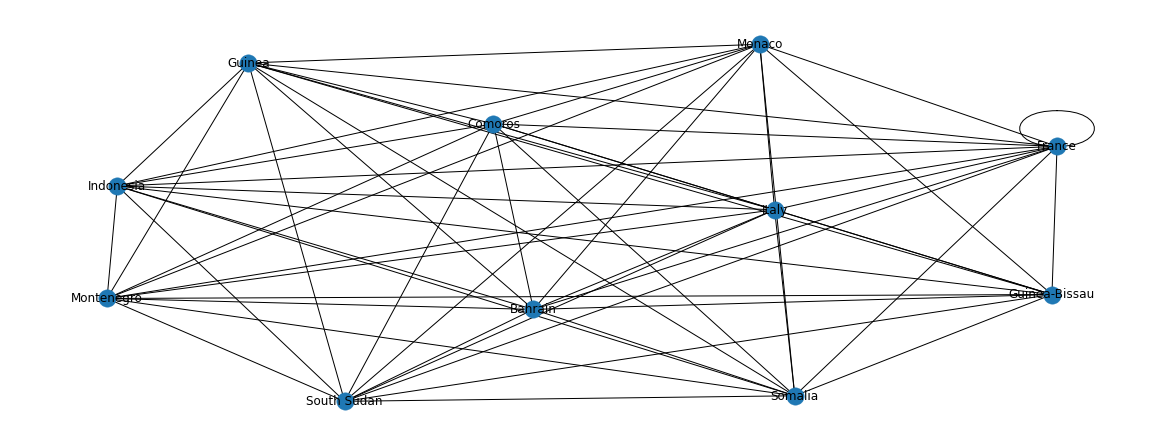

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()

for edge in edges_2:
   g.add_edge(edge[0],edge[1])
nx.draw(g,with_labels=True)
plt.show()